<a href="https://colab.research.google.com/github/berryew/DREAM-PTD-Prediction-Using-Microarray/blob/master/DREAM_Survival_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install packages, import them, and load the dataset

In [1]:
!pip install Biopython
!pip install lifelines

     |████████████████████████████████| 2.3MB 9.6MB/s 
     |████████████████████████████████| 389kB 9.4MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from pathlib import Path
DATA = Path("/content/drive/My Drive/E4060/DREAM/data")

In [0]:
import pandas as pd
import numpy as np

from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils import shuffle

import xgboost as xgb

from Bio.Cluster import kcluster

from collections import Counter

from sklearn.cluster import AgglomerativeClustering
from sklearn.neural_network import MLPClassifier

In [0]:
# load the microarray
# Just `eset_SC2_v20.csv` and `anoSC2_v20_nokey.csv` will be sufficient. 
# `eset_SC2_v20.csv` contains information of both `HuGene21ST_RMA.csv` and `HTA20_RMA.csv`
eset = pd.read_csv(DATA / "eset_SC2_v20.csv", index_col=0)
# load the annotation
annot = pd.read_csv(DATA / "anoSC2_v20_nokey.csv")

### Calculate the concordance index
It usually takes a while, so it is ran only once and save as csv for later use.

In [6]:
from tqdm import tqdm
from lifelines.utils import concordance_index

T2 = annot.sort_values('GA', ascending=False).drop_duplicates(['IndividualID'])


stages = ['', '_T2']

for sidx, stage in enumerate(stages):
    if sidx == 0:
        train_id = annot[annot.Train==1].SampleID
    else:
        train_id = T2[T2.Train==1].SampleID
    X_sa = eset.loc[:, eset.columns.isin(train_id)]
    y_sa = annot.loc[annot.SampleID.isin(train_id), ['Group', 'TTD']]
    y_sa['Group'] = y_sa.Group != 'Control'
    y_sa['Event'] = True
    y_sa.index = X_sa.columns

    X_y_sa = pd.concat([X_sa, y_sa.transpose()])

    out = []

    # calculate concordance index for all genes
    for i in tqdm(range(0, X_y_sa.shape[0] - 3), total=X_y_sa.shape[0] - 3):
        out.append((X_y_sa.index[i],
                    concordance_index(X_y_sa.loc['TTD'], X_y_sa.iloc[i], X_y_sa.loc['Event'])))
    cidx_df = pd.DataFrame(out)
    cidx_df.columns = ["gene", "cidx"]
    cidx_df["dev_from_random"] = (cidx_df.cidx - 0.5).abs()
    cidx_df.sort_values("dev_from_random", ascending=False, inplace=True)
    cidx_df.to_csv("/content/drive/My Drive/E4060/DREAM/data/Concordance_results" + stage + ".csv", index=False)

100%|██████████| 29459/29459 [01:38<00:00, 299.91it/s]


### Define SampleID-IndividualID map, xgboost parameters, and functions

In [0]:
# create a SampleID-IndividualID map, so that we can group by IndividualID and calculate the average
sample_to_individual = pd.Series(annot.IndividualID.values, index=annot.SampleID).to_dict()

In [0]:
# define xgboost (survival model) parameters
xgb_params = [
{
    "eta": 0.01,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 5,
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "seed": 4060
},
{
    "eta": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "max_depth": 10,
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "seed": 4060
}, 
{
    "eta": 0.01,
    "subsample": 0.5,
    "colsample_bytree": 0.5,
    "max_depth": 5,
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "seed": 4060
}]

In [0]:
'''
`X_train`: training set input
`y_train`: training set output
`X_test`: validation input
`xgb_params`: tune parameters inside the cv of model training
output the normalized scores, as probabilities
'''
def xgb_prediction(X_train, y_train, X_test, xgb_params):
    cv_scores = []
    cv_rounds = []
    dtrain = xgb.DMatrix(X_train, label=y_train)
    for params in xgb_params:
        cvout = xgb.cv(params, dtrain, num_boost_round=500, nfold=5,
                    early_stopping_rounds=10)
        # get the best (minimum) loss score
        cv_scores.append(cvout["test-cox-nloglik-mean"].min())
        cv_rounds.append(cvout["test-cox-nloglik-mean"].idxmin())
    print(cv_scores, cv_rounds)
    xgbmodel = xgb.train(xgb_params[np.argmin(cv_scores)],
                     dtrain, num_boost_round=cv_rounds[np.argmin(cv_scores)])
    dtest = xgb.DMatrix(X_test)
    pred = xgbmodel.predict(dtest)
    # normalize the risk score, so that it can be treated as a probability
    return normalize(pred)

In [0]:
'''
`X` defines the whole dataset, train and test are the index of validation split
`method` defines clustering methods, either kmeans or hierarchical 
    * the parameters of hierarchical clustering can be set as hierarchical.euclidean.average for example
`n_cluster` defines the maximum clusters
    * based on the cllustering, leave out clusters with much less genes, and generate the features by calculate the means of each cluster
`df` decides the type of output, pandas DataFrame or numpy array
'''
def mean_by_cluster(X, train, test, n_cluster=5, method='kmeans', df=True):
    
    # clustering, defined by argument `method`
    if method == 'kmeans':
        clusterid, error, nfound = kcluster(np.array(X.iloc[train].transpose()), nclusters=n_cluster)
    elif method.startswith('hierarchical'):
        _, affinity, linkage = method.split(".")
        cluster = AgglomerativeClustering(n_clusters=n_cluster, affinity=affinity, linkage=linkage)
        cluster.fit_predict(np.array(X.iloc[train].transpose()))
        clusterid = cluster.labels_

    metagenes = X.transpose().copy()
    metagenes = metagenes.reset_index(drop=True)
    metagenes['id'] = clusterid
    metagenes['size'] = metagenes.groupby('id').size()
    # candidate_condition = metagenes['size'] > 0.4 * X.shape[1]//n_cluster
    candidate_condition = metagenes['size'] > max(0.4 * X.shape[1]//n_cluster, 3)
    metagenes = metagenes.groupby('id').mean()
    # print(metagenes['size'] > 0.5 * X.shape[0]//n_cluster)
    metagenes = metagenes[candidate_condition]
    print('Before | After deleting clusters with much less objects: {} | {}'.format(Counter(clusterid), metagenes.shape[0]))
    if df:
        return metagenes.iloc[:, train].transpose(), metagenes.iloc[:, test].transpose()
    else:
        return np.array(metagenes.iloc[:, train].transpose()), np.array(metagenes.iloc[:, test].transpose())
    

In [0]:
'''
normalize the value to range from 0 to 1
'''
def normalize(array):
    return (array - min(array)) / (max(array) - min(array))

### Whole Training Set v.s. The Latest Sample

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Before | After deleting clusters with much less objects: Counter({0: 36, 5: 19, 1: 13, 6: 10, 2: 10, 9: 4, 3: 3, 4: 3, 8: 1, 7: 1}) | 5
True sample in training | test: 125 | 25
[3.3057722, 3.3224877999999998, 3.303731] [106, 75, 154]
Before | After deleting clusters with much less objects: Counter({4: 25, 5: 19, 1: 13, 3: 11, 2: 10, 6: 10, 0: 7, 7: 3, 8: 1, 9: 1}) | 7
True sample in training | test: 125 | 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[3.2831816000000003, 3.2904942, 3.294625] [147, 105, 160]
Before | After deleting clusters with much less objects: Counter({0: 36, 5: 19, 3: 12, 2: 10, 1: 8, 4: 7, 6: 3, 7: 3, 8: 1, 9: 1}) | 6
True sample in training | test: 125 | 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[3.3185145999999994, 3.3369082, 3.3186768] [108, 64, 129]
Before | After deleting clusters with much less objects: Counter({9: 27, 2: 24, 3: 11, 4: 10, 1: 10, 0: 7, 8: 6, 6: 3, 7: 1, 5: 1}) | 7
True sample in training | test: 125 | 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[3.3262789999999995, 3.3324009999999995, 3.32594] [100, 77, 117]
Before | After deleting clusters with much less objects: Counter({3: 30, 2: 24, 4: 10, 1: 10, 9: 8, 0: 7, 8: 6, 6: 3, 7: 1, 5: 1}) | 7
True sample in training | test: 125 | 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[3.2894954, 3.3028724000000005, 3.2940714] [150, 100, 162]
Before | After deleting clusters with much less objects: Counter({2: 40, 5: 11, 7: 11, 3: 10, 1: 10, 0: 7, 4: 6, 6: 3, 8: 1, 9: 1}) | 7
True sample in training | test: 125 | 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[3.3328842, 3.3437216, 3.3291086] [78, 74, 134]


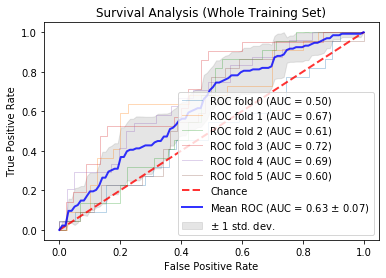

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Before | After deleting clusters with much less objects: Counter({0: 31, 2: 18, 5: 13, 3: 12, 1: 9, 4: 8, 8: 6, 6: 1, 7: 1, 9: 1}) | 7
True sample in training | test: 53 | 11
[2.5909568, 2.5985836000000004, 2.580569] [83, 75, 125]
Before | After deleting clusters with much less objects: Counter({1: 18, 2: 17, 9: 16, 4: 15, 3: 12, 0: 11, 8: 8, 6: 1, 5: 1, 7: 1}) | 7
True sample in training | test: 53 | 11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.5448534, 2.5659662, 2.5292323999999997] [139, 102, 236]
Before | After deleting clusters with much less objects: Counter({1: 26, 0: 17, 4: 17, 3: 14, 8: 12, 9: 6, 2: 5, 6: 1, 5: 1, 7: 1}) | 7
True sample in training | test: 53 | 11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.5726742, 2.572862, 2.57343] [93, 90, 127]
Before | After deleting clusters with much less objects: Counter({1: 25, 0: 24, 2: 13, 8: 12, 3: 9, 4: 8, 7: 6, 6: 1, 5: 1, 9: 1}) | 7
True sample in training | test: 53 | 11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.5810568, 2.5854016, 2.5869644000000003] [79, 78, 105]
Before | After deleting clusters with much less objects: Counter({0: 31, 5: 13, 1: 13, 2: 13, 3: 12, 4: 9, 8: 6, 6: 1, 7: 1, 9: 1}) | 7
True sample in training | test: 54 | 10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.590438, 2.6041043999999998, 2.5936500000000002] [94, 69, 107]
Before | After deleting clusters with much less objects: Counter({0: 31, 5: 13, 1: 13, 2: 13, 3: 12, 4: 9, 8: 6, 6: 1, 7: 1, 9: 1}) | 7
True sample in training | test: 54 | 10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.5197586, 2.5399921999999995, 2.545084] [119, 85, 107]


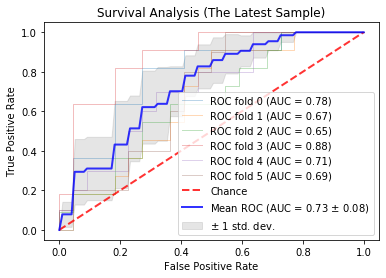

In [73]:
titles = ['(Whole Training Set)', '(The Latest Sample)']

for j in range(2):
    if j == 0:
        # select all the samples from the training set
        cidx_df = pd.read_csv(DATA / "Concordance_results.csv", index_col=0)
        train_id = annot[annot.Train==1].SampleID
    else:
        # select the latest samples (by GA)
        cidx_df = pd.read_csv(DATA / "Concordance_results_T2.csv", index_col=0)
        T2 = annot.sort_values('GA', ascending=False).drop_duplicates(['IndividualID'])
        train_id = T2[T2.Train==1].SampleID
    
    # select top 100 genes based on concordance index
    cidx_top_genes = cidx_df.index[:100]
    X_sa = eset.loc[cidx_top_genes, eset.columns.isin(train_id)].transpose()
    y_sa = annot.loc[annot.SampleID.isin(train_id), ['Group', 'TTD']]
    y_sa['Group'] = y_sa.Group != 'Control'
    y_sa['Event'] = True
    y_sa.index = X_sa.index
    X_y_sa = pd.concat([X_sa, y_sa], axis=1)


    X, y = shuffle(X_sa, y_sa, random_state=4060)
    y_TTD, y_Group = y.TTD.values, y.Group.values

    method = ['kmeans', 'hierarchical.euclidean.ward', 'hierarchical.euclidean.complete', 'hierarchical.average', 'hierarchical.single']

    # 6-fold stratified cross validation
    cv = StratifiedKFold(n_splits=6)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y_Group):

        y_train, y_test = y_TTD[train], y_Group[test]
        X_train, X_test = mean_by_cluster(X, train, test, 10, 'hierarchical.euclidean.complete')
        print("True sample in training | test: {} | {}".format(sum(y_Group[train]), sum(y_Group[test])))
        probas_ = xgb_prediction(X_train, y_train, X_test, xgb_params)

        # map sample-prediction to patient-prediction by calculating the mean
        output = pd.DataFrame({'SampleID': y.Group[test].index, 'Prediction': probas_})
        output['IndividualID'] = output['SampleID'].map(sample_to_individual)
        output = output.merge(y.Group, left_on='SampleID', right_index=True)
        output = output.groupby('IndividualID').max()

        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(output.Group, output.Prediction)
        # fpr, tpr, thresholds = roc_curve(y_test, probas_)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Survival Analysis ' + titles[j])
    plt.legend(loc="lower right")
    # plt.savefig('/content/drive/My Drive/E4060/DREAM/report/Survival Analysis ' + titles[j] + '.png')
    plt.show()

### Compare different clustering methods

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Before | After deleting clusters with much less objects: Counter({5: 23, 7: 15, 6: 15, 1: 14, 9: 12, 4: 9, 0: 4, 3: 4, 8: 2, 2: 2}) | 6
True sample in training | test: 53 | 11
[2.5881558, 2.5731558, 2.5856871999999997] [88, 77, 97]
Before | After deleting clusters with much less objects: Counter({1: 23, 0: 16, 2: 15, 9: 14, 3: 12, 8: 9, 5: 5, 4: 2, 6: 2, 7: 2}) | 7
True sample in training | test: 53 | 11
[2.588819, 2.5989926, 2.5733666] [89, 70, 134]
Before | After deleting clusters with much less objects: Counter({2: 20, 5: 15, 7: 14, 6: 12, 8: 10, 4: 9, 3: 9, 9: 8, 0: 2, 1: 1}) | 8
True sample in training | test: 53 | 11
[2.5327766000000005, 2.5428128, 2.5295866] [120, 100, 143]
Before | After deleting clusters with much less objects: Counter({0: 23, 5: 14, 4: 14, 1: 13, 7: 12, 8: 7, 2: 6, 6: 5, 3: 4, 9: 2}) | 8
True sample in training | test: 53 | 11
[2.5681988, 2.5680970000000003, 2.5646234] [94, 108, 105]
Before | After deleting clusters with much less objects: Counter({4: 20, 5: 

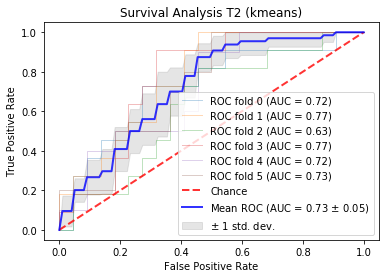

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Before | After deleting clusters with much less objects: Counter({2: 19, 1: 19, 4: 13, 9: 12, 6: 12, 3: 9, 8: 7, 7: 6, 0: 2, 5: 1}) | 8
True sample in training | test: 53 | 11
[2.5801576, 2.5886662, 2.5687729999999998] [90, 77, 109]
Before | After deleting clusters with much less objects: Counter({4: 18, 1: 16, 6: 13, 2: 13, 7: 12, 9: 10, 3: 9, 8: 6, 0: 2, 5: 1}) | 8
True sample in training | test: 53 | 11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.553963, 2.565963, 2.5458494] [106, 84, 137]
Before | After deleting clusters with much less objects: Counter({0: 27, 2: 19, 6: 16, 4: 13, 1: 9, 3: 7, 7: 6, 9: 1, 8: 1, 5: 1}) | 7
True sample in training | test: 53 | 11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.5282776, 2.5475714, 2.5249102] [108, 84, 160]
Before | After deleting clusters with much less objects: Counter({0: 27, 2: 19, 6: 16, 4: 13, 1: 9, 3: 7, 7: 6, 9: 1, 8: 1, 5: 1}) | 7
True sample in training | test: 53 | 11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.5800908, 2.5905744, 2.5864314] [100, 82, 126]
Before | After deleting clusters with much less objects: Counter({3: 18, 0: 18, 2: 17, 1: 16, 4: 13, 6: 9, 8: 6, 9: 1, 7: 1, 5: 1}) | 7
True sample in training | test: 54 | 10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.6000652, 2.6069682, 2.5984694] [83, 58, 108]
Before | After deleting clusters with much less objects: Counter({1: 19, 9: 18, 4: 13, 2: 13, 6: 12, 3: 9, 8: 7, 7: 6, 0: 2, 5: 1}) | 8
True sample in training | test: 54 | 10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.5360016, 2.5340986, 2.531903] [101, 119, 125]


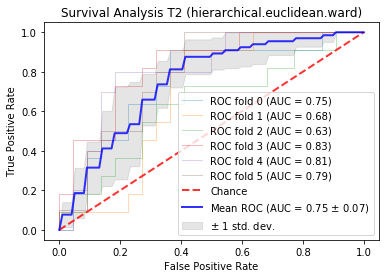

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Before | After deleting clusters with much less objects: Counter({0: 31, 2: 18, 5: 13, 3: 12, 1: 9, 4: 8, 8: 6, 6: 1, 7: 1, 9: 1}) | 7
True sample in training | test: 53 | 11
[2.5909568, 2.5985836000000004, 2.580569] [83, 75, 125]
Before | After deleting clusters with much less objects: Counter({1: 18, 2: 17, 9: 16, 4: 15, 3: 12, 0: 11, 8: 8, 6: 1, 5: 1, 7: 1}) | 7
True sample in training | test: 53 | 11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.5448534, 2.5659662, 2.5292323999999997] [139, 102, 236]
Before | After deleting clusters with much less objects: Counter({1: 26, 0: 17, 4: 17, 3: 14, 8: 12, 9: 6, 2: 5, 6: 1, 5: 1, 7: 1}) | 7
True sample in training | test: 53 | 11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.5726742, 2.572862, 2.57343] [93, 90, 127]
Before | After deleting clusters with much less objects: Counter({1: 25, 0: 24, 2: 13, 8: 12, 3: 9, 4: 8, 7: 6, 6: 1, 5: 1, 9: 1}) | 7
True sample in training | test: 53 | 11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.5810568, 2.5854016, 2.5869644000000003] [79, 78, 105]
Before | After deleting clusters with much less objects: Counter({0: 31, 5: 13, 1: 13, 2: 13, 3: 12, 4: 9, 8: 6, 6: 1, 7: 1, 9: 1}) | 7
True sample in training | test: 54 | 10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.590438, 2.6041043999999998, 2.5936500000000002] [94, 69, 107]
Before | After deleting clusters with much less objects: Counter({0: 31, 5: 13, 1: 13, 2: 13, 3: 12, 4: 9, 8: 6, 6: 1, 7: 1, 9: 1}) | 7
True sample in training | test: 54 | 10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.5197586, 2.5399921999999995, 2.545084] [119, 85, 107]


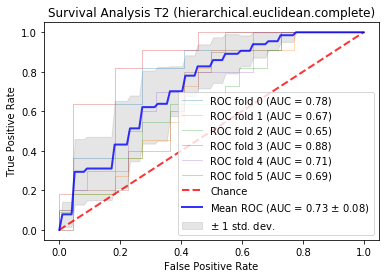

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Before | After deleting clusters with much less objects: Counter({2: 31, 1: 21, 0: 16, 3: 13, 8: 9, 6: 6, 9: 1, 7: 1, 5: 1, 4: 1}) | 6
True sample in training | test: 53 | 11
[2.563983, 2.5766594, 2.5675532000000003] [100, 88, 109]
Before | After deleting clusters with much less objects: Counter({1: 23, 3: 20, 0: 16, 2: 13, 4: 10, 8: 9, 6: 6, 9: 1, 7: 1, 5: 1}) | 7
True sample in training | test: 53 | 11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.5272175999999997, 2.5491212, 2.5375292] [138, 127, 191]
Before | After deleting clusters with much less objects: Counter({1: 31, 0: 18, 2: 13, 3: 12, 8: 9, 4: 8, 6: 6, 9: 1, 7: 1, 5: 1}) | 7
True sample in training | test: 53 | 11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.5394616, 2.5499938, 2.5534506] [107, 87, 105]
Before | After deleting clusters with much less objects: Counter({0: 23, 3: 19, 1: 16, 2: 13, 4: 11, 8: 9, 6: 6, 9: 1, 7: 1, 5: 1}) | 7
True sample in training | test: 53 | 11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.5825418, 2.5907744, 2.5832577999999997] [80, 79, 126]
Before | After deleting clusters with much less objects: Counter({1: 22, 3: 21, 0: 16, 2: 13, 4: 10, 8: 9, 6: 6, 9: 1, 7: 1, 5: 1}) | 7
True sample in training | test: 54 | 10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.5873966000000004, 2.5978825999999997, 2.5853341999999997] [62, 64, 114]
Before | After deleting clusters with much less objects: Counter({1: 30, 3: 18, 2: 13, 0: 13, 8: 9, 4: 8, 6: 6, 9: 1, 7: 1, 5: 1}) | 7
True sample in training | test: 54 | 10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[2.5480038, 2.5454684, 2.5456648] [116, 136, 151]


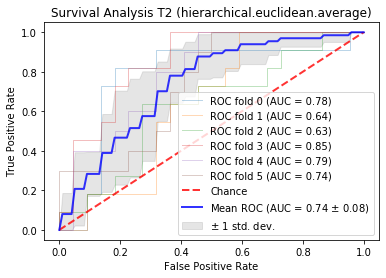

In [74]:
method = ['kmeans', 'hierarchical.euclidean.ward', 'hierarchical.euclidean.complete', 'hierarchical.euclidean.average']

for j in range(len(method)):
    cidx_df = pd.read_csv(DATA / "Concordance_results_T2.csv", index_col=0)
    T2 = annot.sort_values('GA', ascending=False).drop_duplicates(['IndividualID'])
    train_id = T2[T2.Train==1].SampleID
    
    cidx_top_genes = cidx_df.index[:100]
    X_sa = eset.loc[cidx_top_genes, eset.columns.isin(train_id)].transpose()
    y_sa = annot.loc[annot.SampleID.isin(train_id), ['Group', 'TTD']]
    y_sa['Group'] = y_sa.Group != 'Control'
    y_sa['Event'] = True
    y_sa.index = X_sa.index
    X_y_sa = pd.concat([X_sa, y_sa], axis=1)


    X, y = shuffle(X_sa, y_sa, random_state=4060)
    y_TTD, y_Group = y.TTD.values, y.Group.values


    cv = StratifiedKFold(n_splits=6)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y_Group):

        y_train, y_test = y_TTD[train], y_Group[test]
        X_train, X_test = mean_by_cluster(X, train, test, 10, method[j])
        print("True sample in training | test: {} | {}".format(sum(y_Group[train]), sum(y_Group[test])))
        probas_ = xgb_prediction(X_train, y_train, X_test, xgb_params)

        output = pd.DataFrame({'SampleID': y.Group[test].index, 'Prediction': probas_})
        output['IndividualID'] = output['SampleID'].map(sample_to_individual)
        output = output.merge(y.Group, left_on='SampleID', right_index=True)
        output = output.groupby('IndividualID').mean()

        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(output.Group, output.Prediction)
        # fpr, tpr, thresholds = roc_curve(y_test, probas_)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Survival Analysis T2 (' + method[j] + ')')
    plt.legend(loc="lower right")
    # plt.savefig('/content/drive/My Drive/E4060/DREAM/report/Survival Analysis T2 (' + method[j] + ').png')
    plt.show()

In [71]:
output.shape, len(y_test)

((32, 2), 32)

### Without clustering (co-expression analysis)

True sample in training | test: 53 | 11
[2.485136, 2.4763074, 2.4603936] [216, 215, 277]
True sample in training | test: 53 | 11
[2.4354884, 2.4262248, 2.435156] [311, 230, 318]
True sample in training | test: 53 | 11
[2.4573868, 2.4496572, 2.4656934] [273, 261, 206]
True sample in training | test: 53 | 11
[2.4783578, 2.461232, 2.4679771999999995] [256, 236, 237]
True sample in training | test: 54 | 10
[2.4877332, 2.4549141999999997, 2.4702018000000003] [210, 255, 261]
True sample in training | test: 54 | 10
[2.4665686, 2.4418683999999997, 2.4708728] [214, 201, 186]


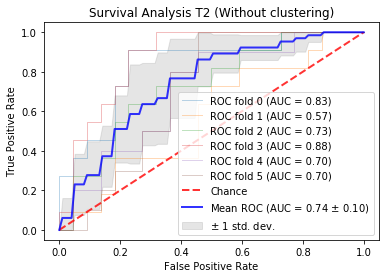

In [72]:
cidx_df = pd.read_csv(DATA / "Concordance_results_T2.csv", index_col=0)
T2 = annot.sort_values('GA', ascending=False).drop_duplicates(['IndividualID'])
train_id = T2[T2.Train==1].SampleID

cidx_top_genes = cidx_df.index[:100]
X_sa = eset.loc[cidx_top_genes, eset.columns.isin(train_id)].transpose()
y_sa = annot.loc[annot.SampleID.isin(train_id), ['Group', 'TTD']]
y_sa['Group'] = y_sa.Group != 'Control'
y_sa['Event'] = True
y_sa.index = X_sa.index
X_y_sa = pd.concat([X_sa, y_sa], axis=1)


X, y = shuffle(X_sa, y_sa, random_state=4060)
y_TTD, y_Group = y.TTD.values, y.Group.values


cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y_Group):

    y_train, y_test = y_TTD[train], y_Group[test]
    X_train, X_test = X.iloc[train], X.iloc[test]
    print("True sample in training | test: {} | {}".format(sum(y_Group[train]), sum(y_Group[test])))
    probas_ = xgb_prediction(X_train, y_train, X_test, xgb_params)

    output = pd.DataFrame({'SampleID': y.Group[test].index, 'Prediction': probas_})
    output['IndividualID'] = output['SampleID'].map(sample_to_individual)
    output = output.merge(y.Group, left_on='SampleID', right_index=True)
    output = output.groupby('IndividualID').mean()

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(output.Group, output.Prediction)
    # fpr, tpr, thresholds = roc_curve(y_test, probas_)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
            label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Survival Analysis T2 (Without clustering)')
plt.legend(loc="lower right")
# plt.savefig('/content/drive/My Drive/E4060/DREAM/report/Survival Analysis T2 (Without clustering).png')
plt.show()